In [1]:
from utilities.io_tools import input_tools
from wums import plot_tools, output_tools
import matplotlib as mpl
import numpy as np
from wums import boostHistHelpers as hh

In [2]:
res, meta, _ = input_tools.read_infile("/scratch/dwalter/results_histmaker/250304_w_z_gen_massiveCharm/w_z_gen_dists_maxFiles_m1_nnpdf31_nnpdf31.hdf5")

In [3]:
res.keys()

dict_keys(['WminusCharmToMuNu', 'WminusmunuPostVFP', 'WplusCharmToMuNu', 'WplusmunuPostVFP', 'meta_info'])

In [4]:
xaxis_labels = {
    "ptGen": r"$pre\ FSR\ p_\mathrm{T}^{\ell}$",
    "absEtaGen": r"$pre\ FSR\ |\eta^{\ell}|$",
    "massVgen": r"pre FSR W mass",
    "absYVgen": r"pre FSR W |Y|", 
    "ptVgen": r"$pre\ FSR\ p_\mathrm{T}^{W}$",
}
# xsec = {
#     "WplusCharmToMuNu": 1607.3778900941979, # +- 4.9247228837888333
#     "WminusCharmToMuNu": 1749.9768825908691, # +- 6.4490475901643940
#     "WplusmunuPostVFP": 11765.9,
#     "WminusmunuPostVFP": 8703.87,
# }

In [5]:
def load(proc, hist):
    h = res[proc]['output'][hist].get()
    h = hh.scaleHist(h, res[proc]["dataset"]["xsec"]*10e6/res[proc]['weight_sum'], createNew=True)
    return h

In [27]:
def plot(h1ds, labels, var, ratio=False, plotname="hists", normalize=False):
    
    linestyles = ["-", "--", ":"][::-1][:len(h1ds)]
    colors = ["black","blue","red"][::-1][:len(h1ds)]
    labels = labels[:len(h1ds)]
    
    if normalize:
        ylabel="a.u."
    else:
        ylabel="Events / bin"

    widths = np.diff(h1ds[0].axes.edges[0])
    
    ymin = None if ratio else 0
    ymax = None

    if normalize:
        ymax = ymax if ymax is not None else max([max(h.values()/(np.sum(h.values())*widths)) for h in h1ds])
        ymin = ymin if ymin is not None else min([min(h.values()/(np.sum(h.values())*widths)) for h in h1ds])
    else:
        ymax = ymax if ymax is not None else max([max(h.values()/widths) for h in h1ds])
        ymin = ymin if ymin is not None else min([min(h.values()/widths) for h in h1ds])
    yrange = ymax - ymin
    ymin = ymin if ymin == 0 else ymin - yrange*0.3
    ymax = ymax + yrange*0.3

    if ratio:
        fig, ax, ratio_axes = plot_tools.figureWithRatio(
            h1ds[0], 
            xlabel=xaxis_labels[var], 
            ylabel=ylabel, 
            rlabel="matched/nominal",
            rrange=(0.5,1.5),
            automatic_scale=False, 
            width_scale=1.2, 
            ylim=(ymin, ymax),
        )
        ax2 = ratio_axes[0]
        x = h1ds[0].axes.edges[0][:-1]
        ax2.plot([min(x), max(x)], [1,1], color="black", linestyle="--")
        
        # for i, h1d in enumerate(h1ds):
        x = h1ds[-1].axes.edges[0][:-1]
        y = h1ds[-1].values()
        yN = h1ds[-2].values()
        # err = np.sqrt(h1ds[2].variances() + h1ds[1].variances())

        ax2.set_xlim((min(x),max(x)))

        if normalize:
            y = y/sum(y)
            yN = yN/sum(yN)

        ax2.step(x, y/yN, color=colors[-1], linestyle=linestyles[-1], label=labels[-1], where="post")

    else:
        fig, ax = plot_tools.figure(
            h1ds[0], 
            xlabel=xaxis_labels[var], 
            ylabel=ylabel, 
            automatic_scale=False, 
            width_scale=1.2, 
            ylim=(ymin, ymax),
        )
    
    for i, h1d in enumerate(h1ds):
        x = h1d.axes.edges[0][:-1]
        y = h1d.values()
        err = np.sqrt(h1d.variances())

        ax.set_xlim((min(x),max(x)))
        ax.set_ylim((0,ymax))

#         ax.set_xlim(26,56)#-2.4,2.4)

        if normalize:
            y = y/sum(y)
        
        ax.step(x, y/widths, color=colors[i], linestyle=linestyles[i], label=labels[i], where="post")
    #     ax.fill_between(x, y - err, y + err, alpha=0.3, color=colors(i), step="post")

    # ax.text(1.0, 1.003, text_dict[base_process], transform=ax.transAxes, fontsize=30,
    #         verticalalignment='bottom', horizontalalignment="right")
    plot_tools.addLegend(ax, ncols=1)
    plot_name = plotname+"_"+var
    if ratio:
        plot_name += "_ratio"

    if normalize:
        plot_name += "_normalized"
        ax.text(1.0, 1.003, "Normalized", transform=ax.transAxes, #fontsize=30,
            verticalalignment='bottom', horizontalalignment="right")
        
    plot_tools.save_pdf_and_png("./250305_WCharm/", plot_name)

In [11]:
WCharmToMuNu = [load("WminusCharmToMuNu", "prefsr_lep"), load("WplusCharmToMuNu", "prefsr_lep")]
WmunuPostVFP = [load("WminusmunuPostVFP", "prefsr_lep"), load("WplusmunuPostVFP", "prefsr_lep")]
print(WmunuPostVFP[0][{"charm":1}].values(flow=True).sum() / WmunuPostVFP[0].values(flow=True).sum())
print(WmunuPostVFP[1][{"charm":1}].values(flow=True).sum() / WmunuPostVFP[1].values(flow=True).sum())

0.1538554622662196
0.10271324187322031


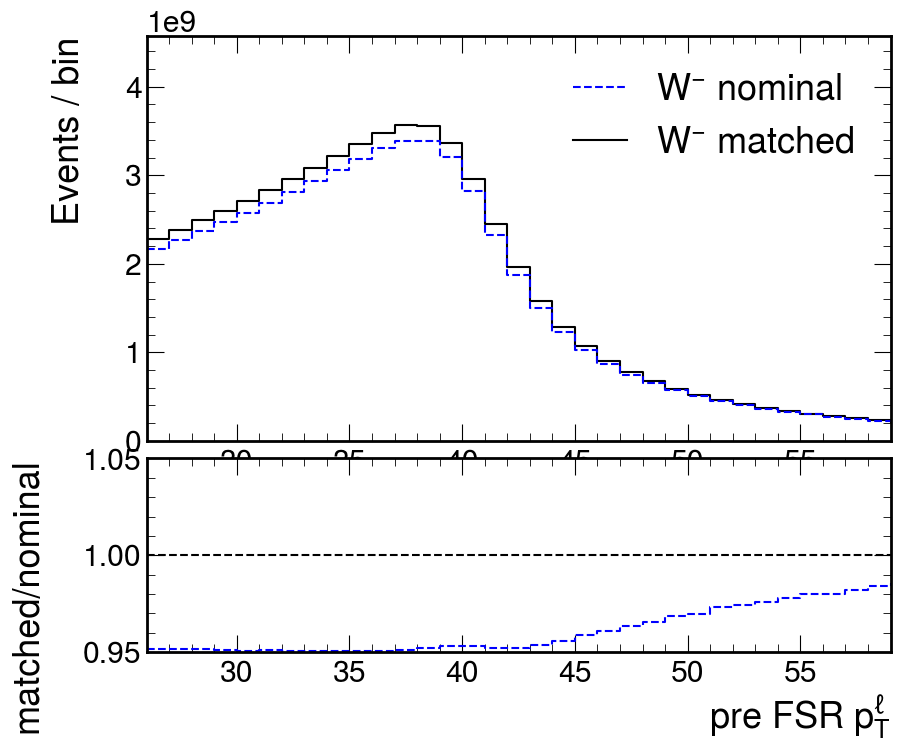

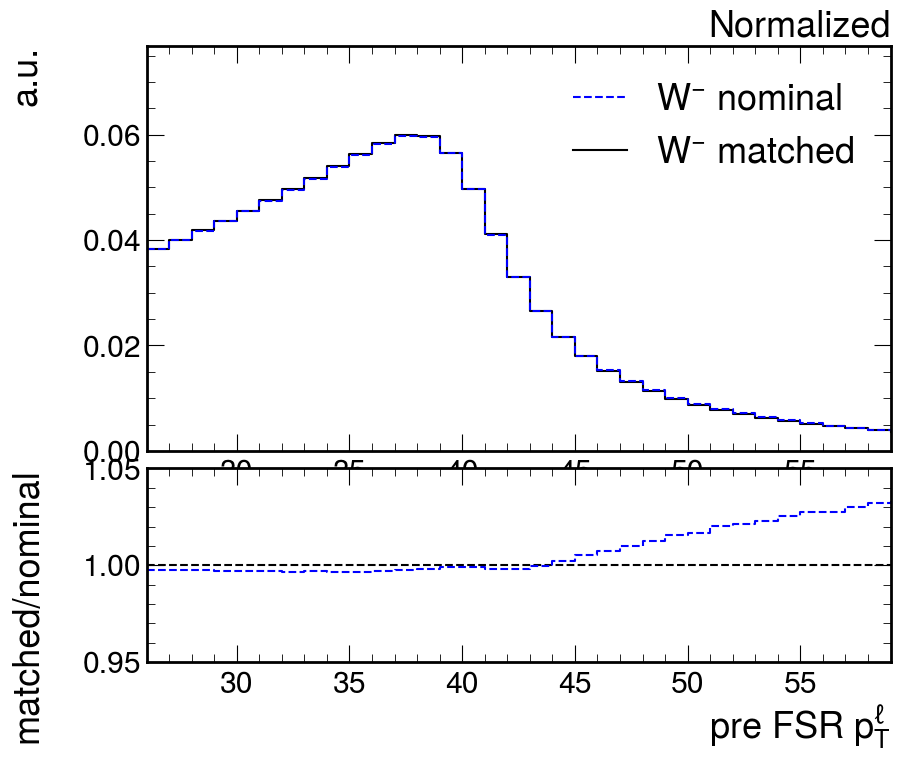

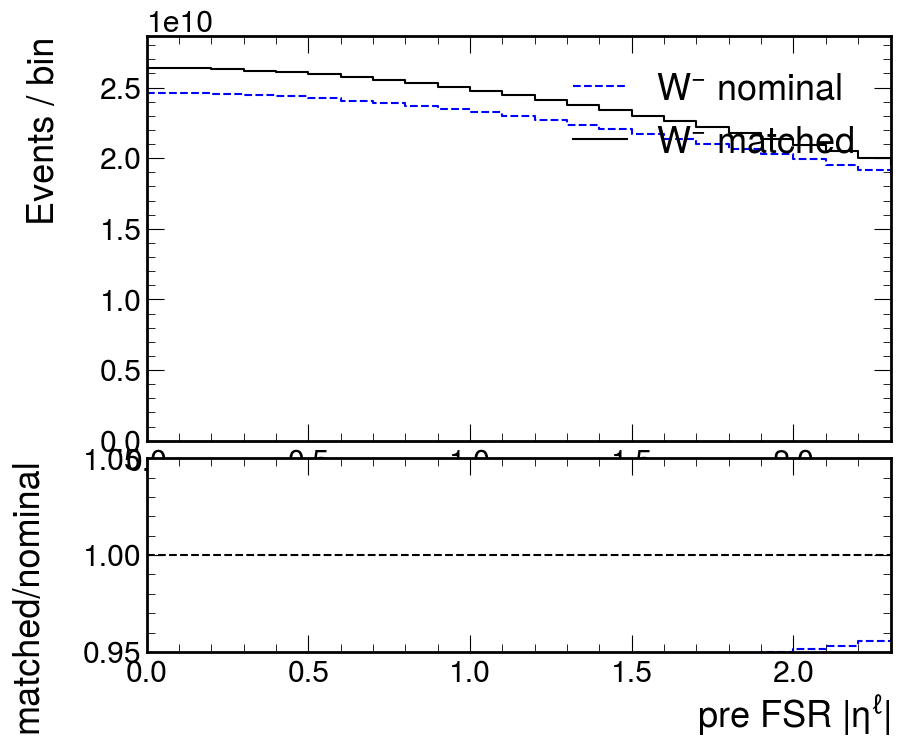

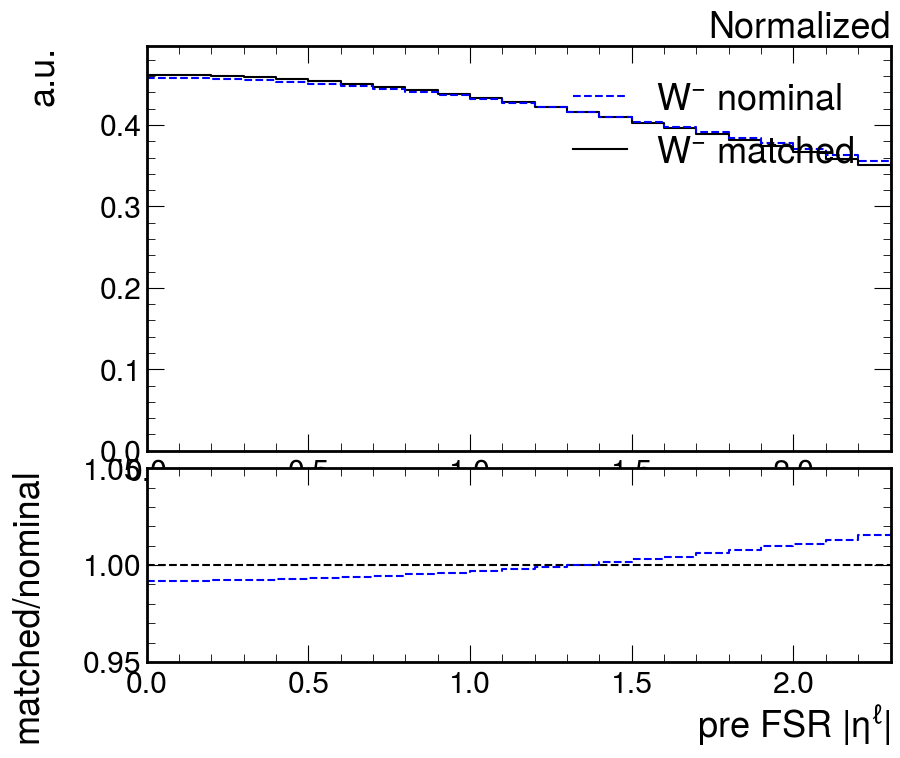

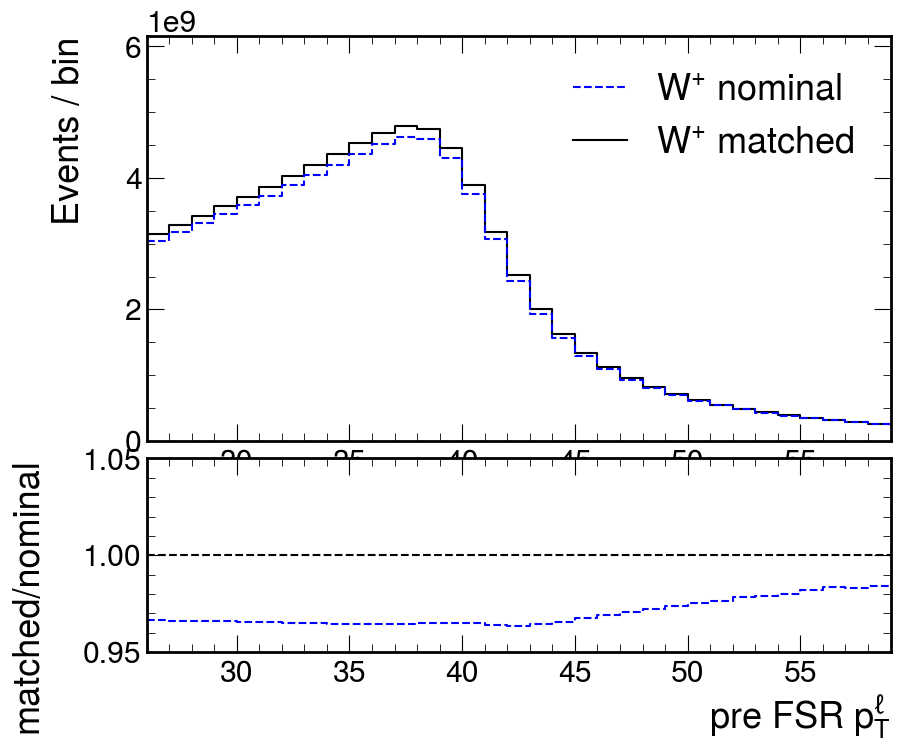

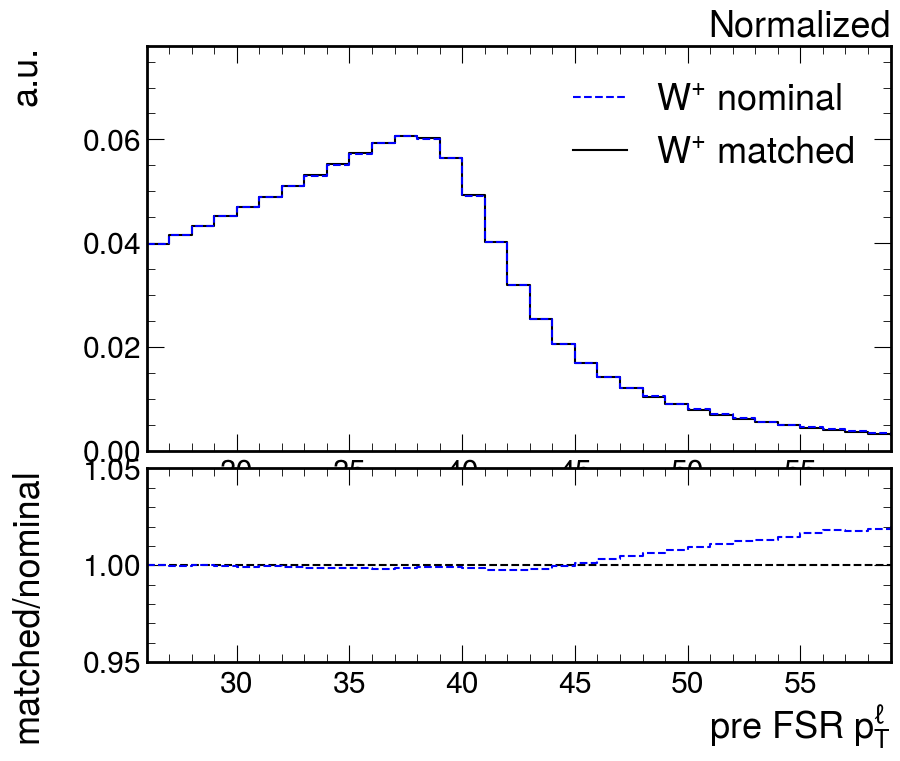

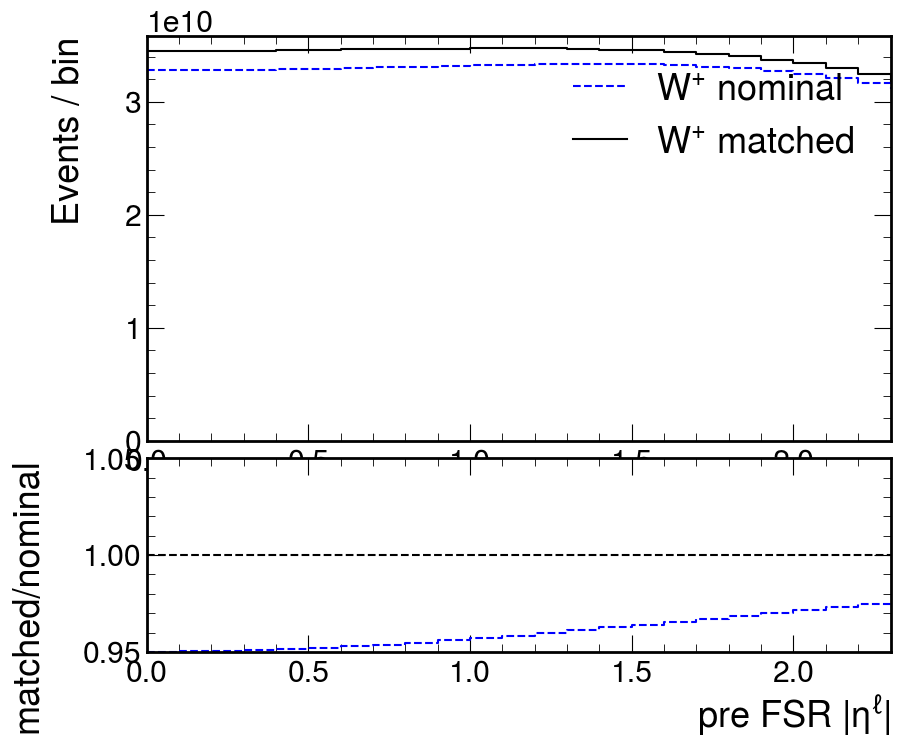

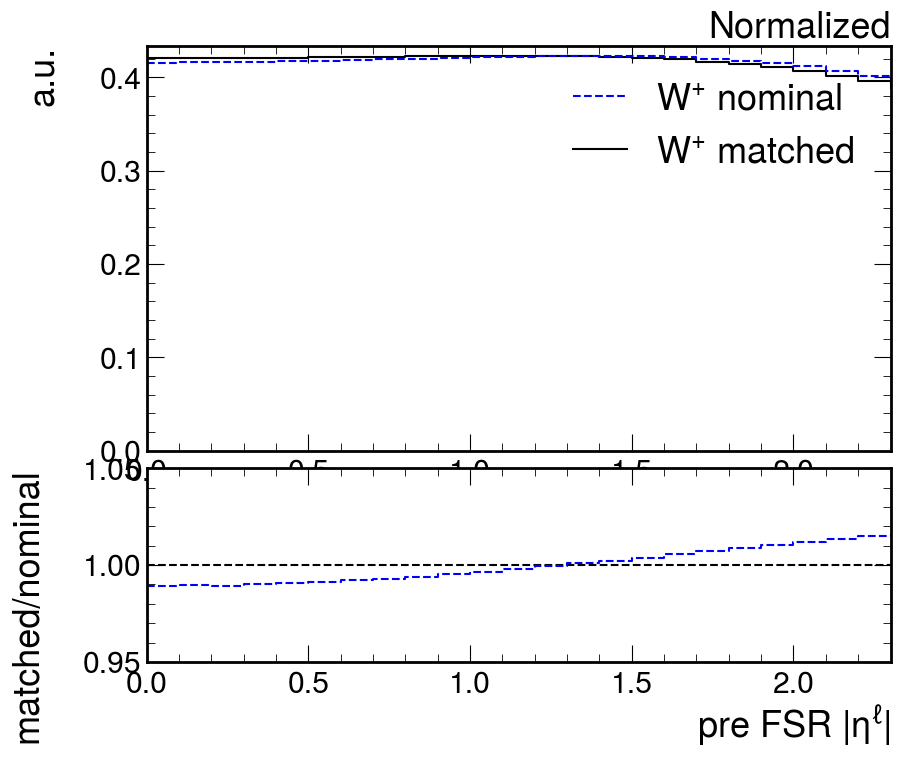

In [12]:
for i, (hCharm, hNominal) in enumerate(zip(WCharmToMuNu, WmunuPostVFP)):
    for var in ["ptGen","absEtaGen"]:
        hC = hCharm.project(var)
        hN = hNominal.project(var)
        hNC = hNominal[{"charm":1}].project(var)
        hNNC = hNominal[{"charm":0}].project(var)
        hM = hh.addHists(hNNC, hC)
        if i==0:
            labels = [r"$W^{-}$ incl.", r"$W^{-}+{c}$ (massive)", r"$W^{-}+{c}$ (massless)"]
            # labels = [r"$W^{-}$ nominal", r"$W^{-}$ matched", ]
        else:
            labels = [r"$W^{+}$ incl.", r"$W^{+}+\bar{c}$ (massive)", r"$W^{+}+\bar{c}$ (massless)"]
            # labels = [r"$W^{+}$ nominal", r"$W^{+}$ matched", ]
            
        plot([hN, hM][::-1], labels[::-1], var, plotname="Wminus" if i==0 else "Wplus", ratio=True)
        plot([hN, hM][::-1], labels[::-1], var, plotname="Wminus" if i==0 else "Wplus", normalize=True, ratio=True)
        # plot([hC, hNC], ["W+c (massive)", "W+c (massless)"], var)

In [17]:
WCharmToMuNu = [load("WminusCharmToMuNu","nominal_gen"), load("WplusCharmToMuNu", "nominal_gen")]
WmunuPostVFP = [load("WminusmunuPostVFP", "nominal_gen"), load("WplusmunuPostVFP", "nominal_gen")]

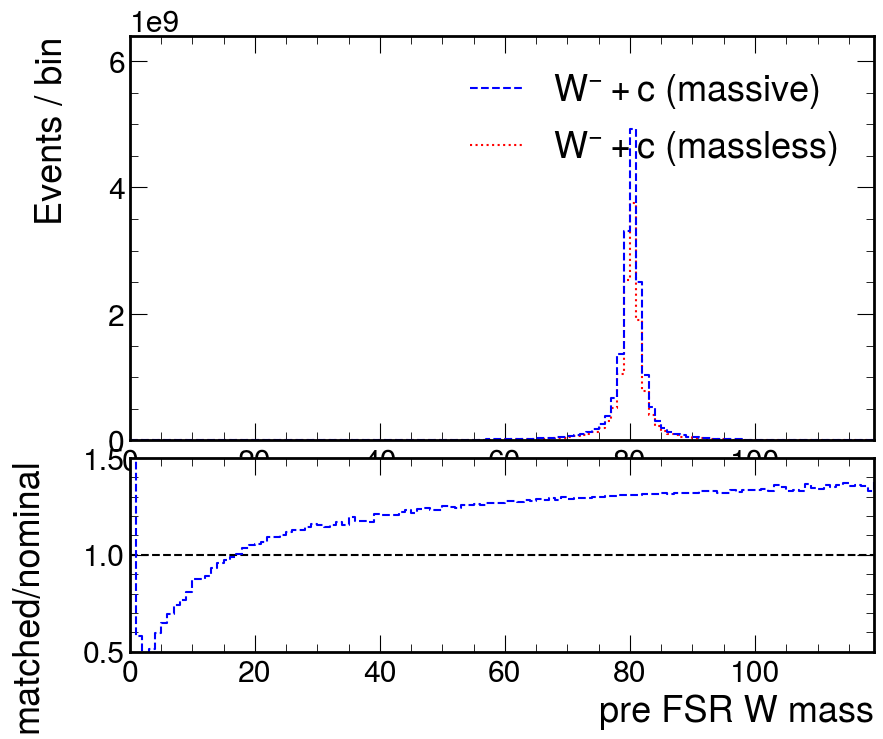

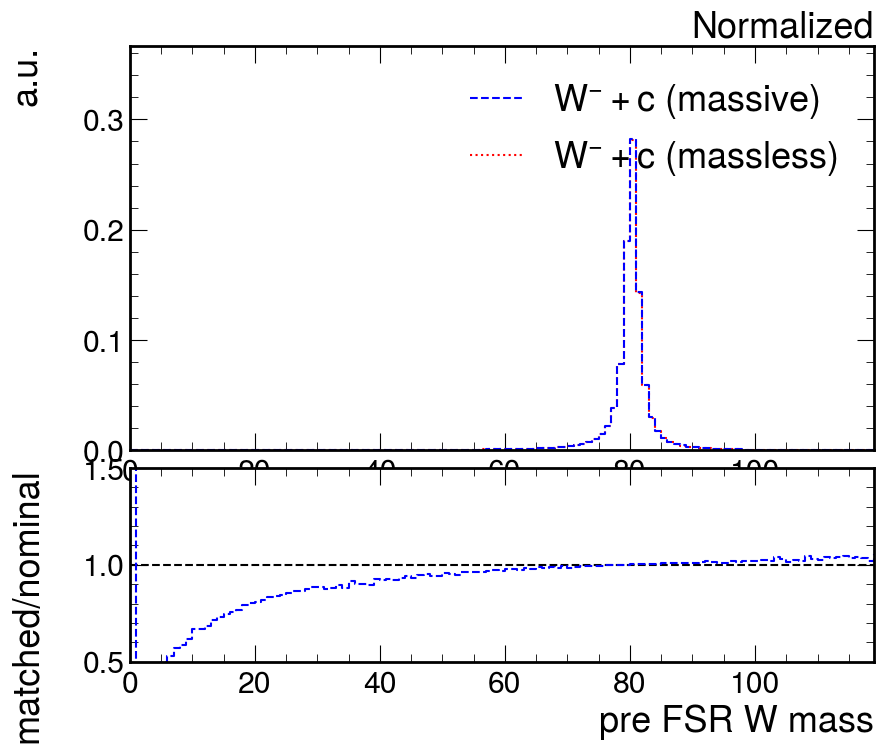

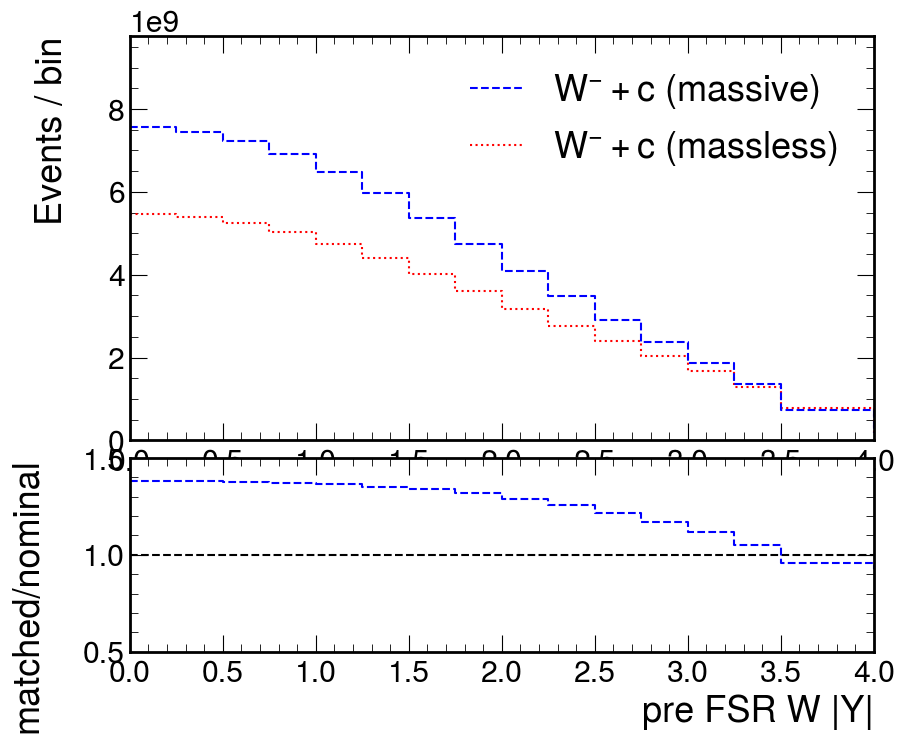

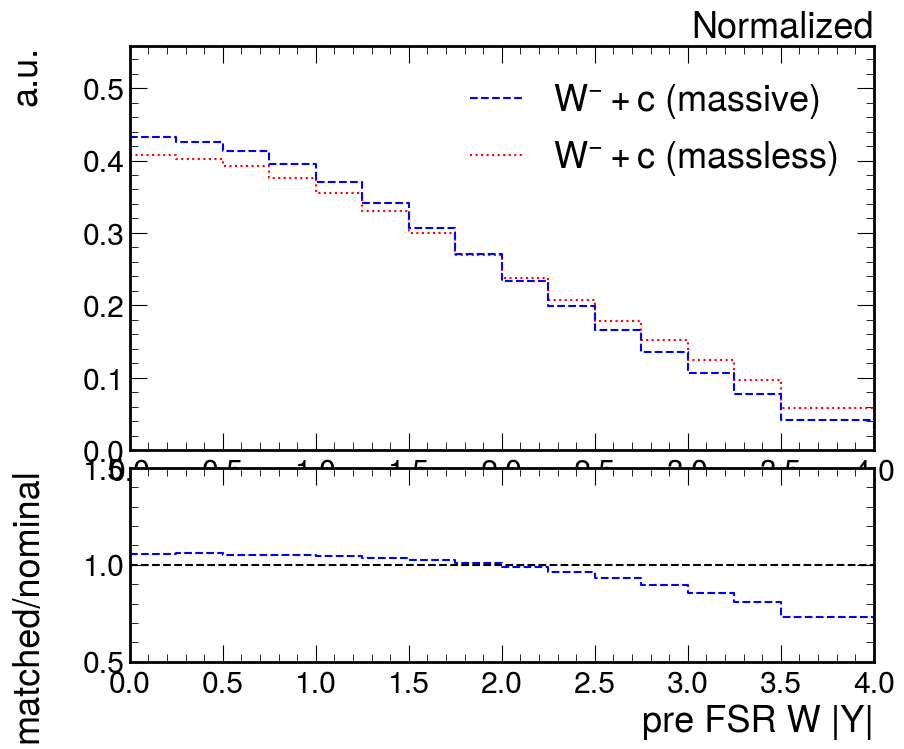

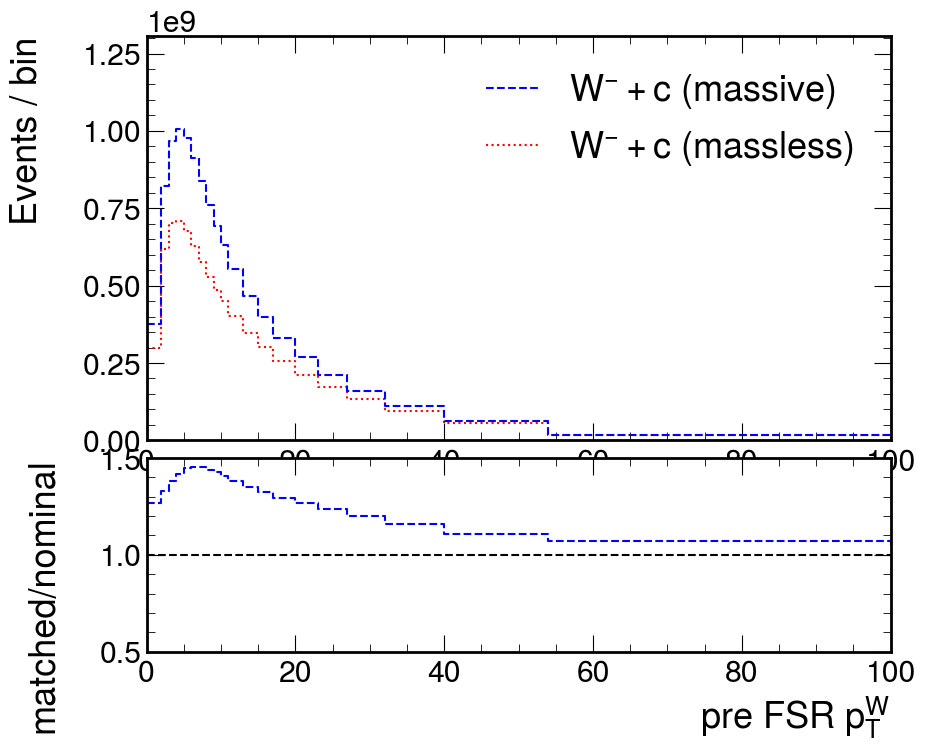

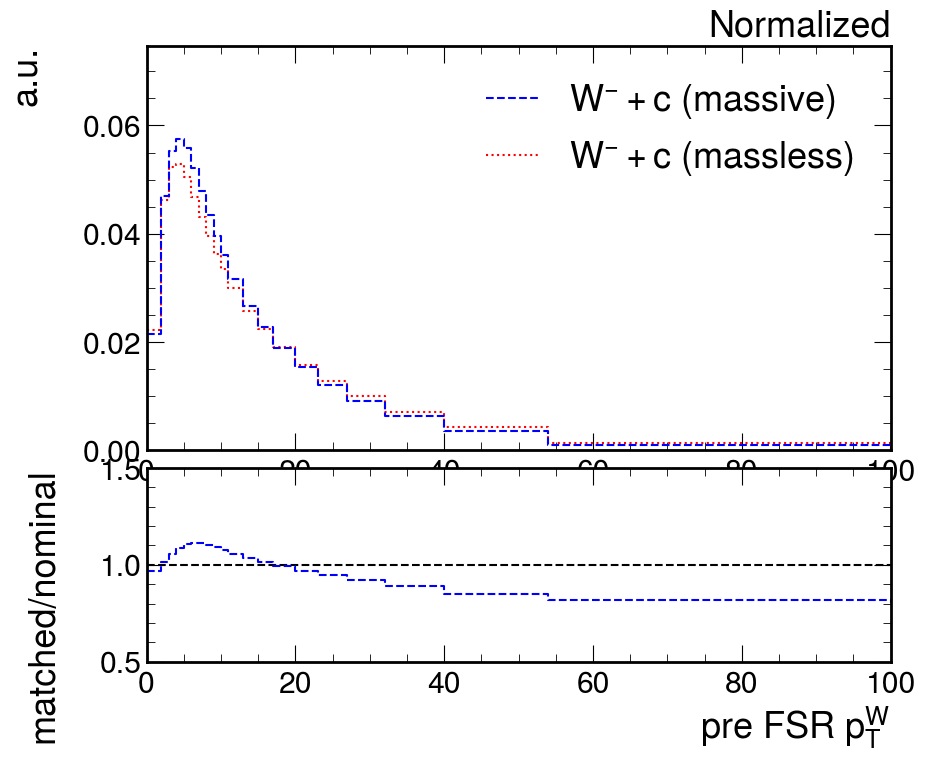

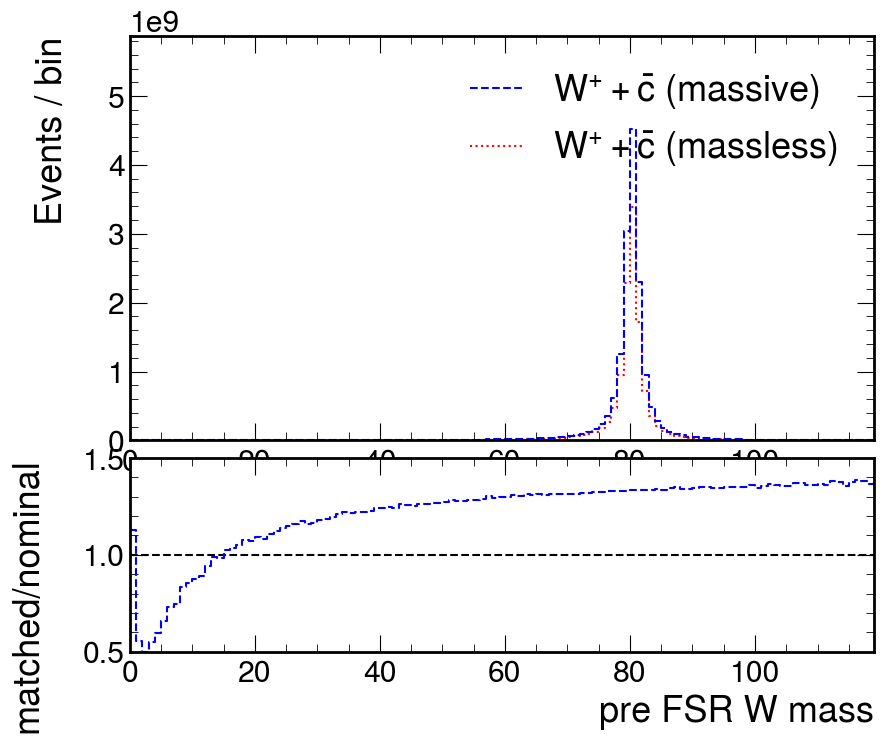

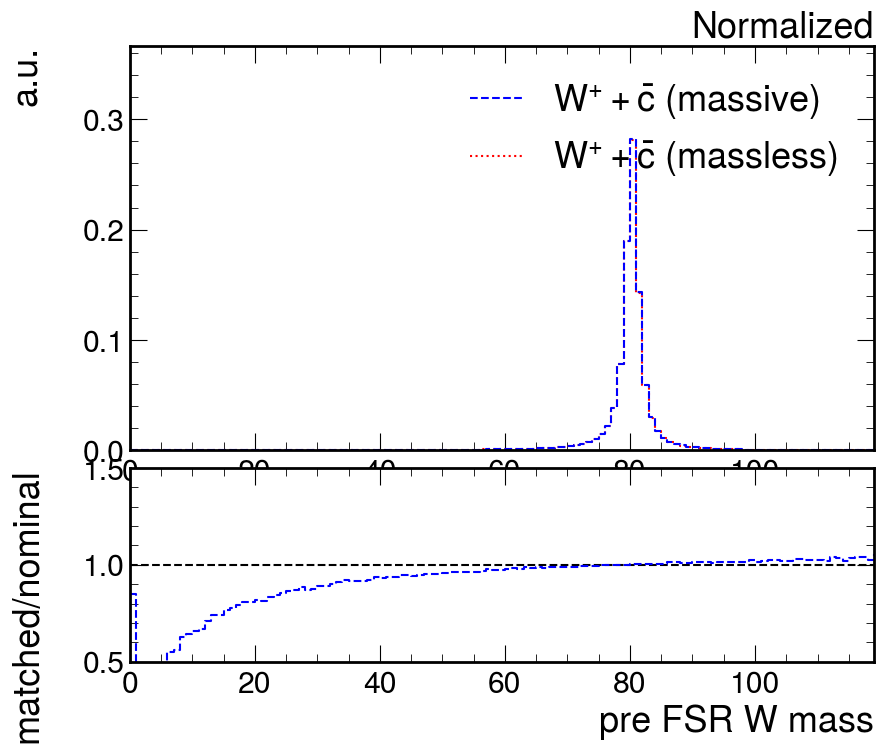

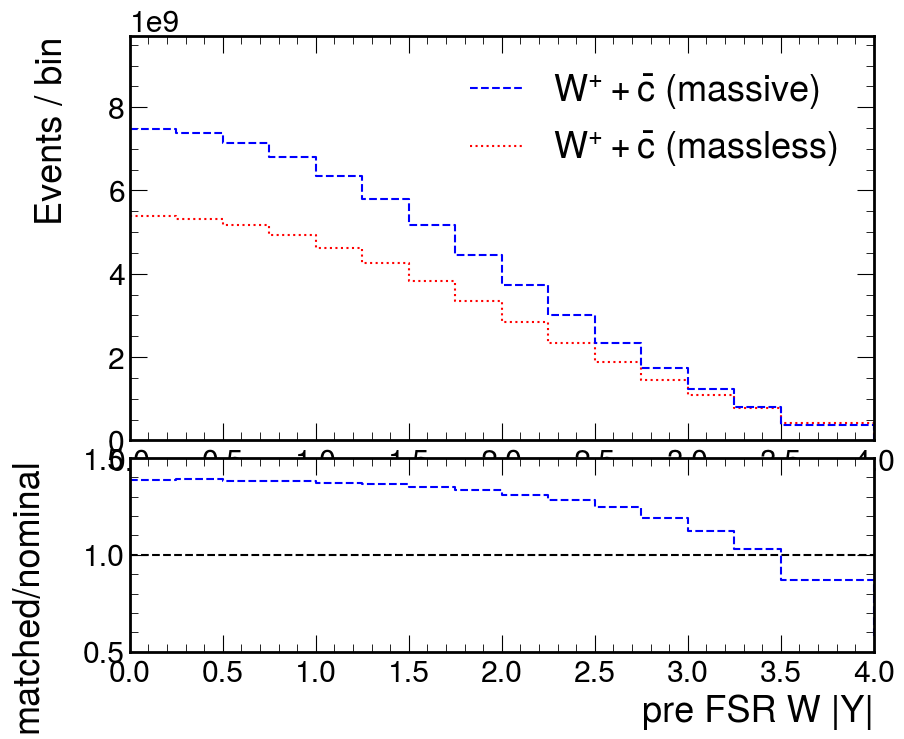

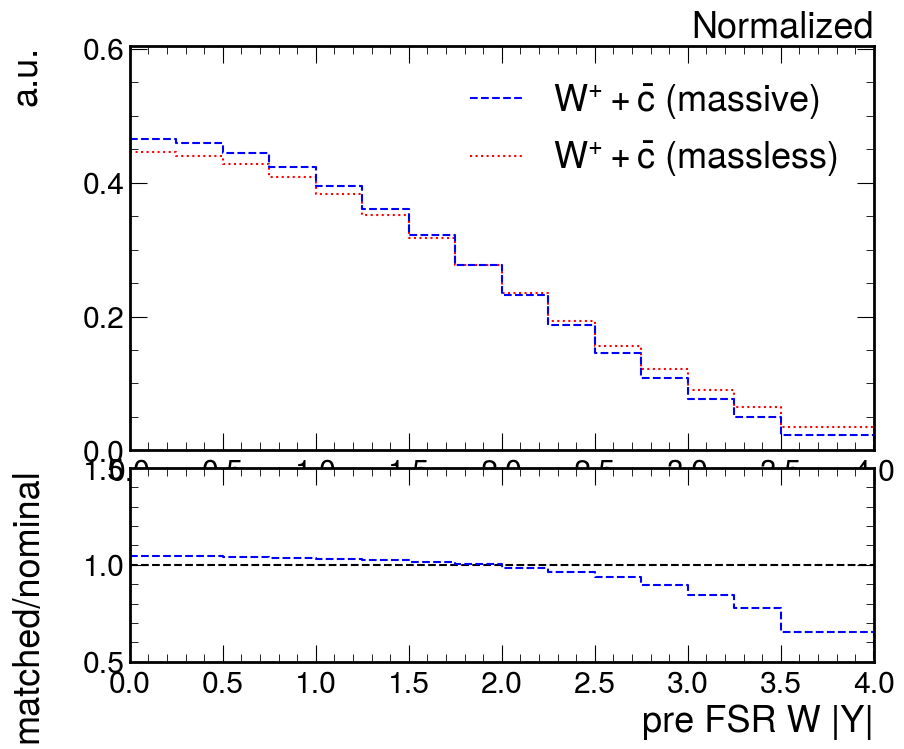

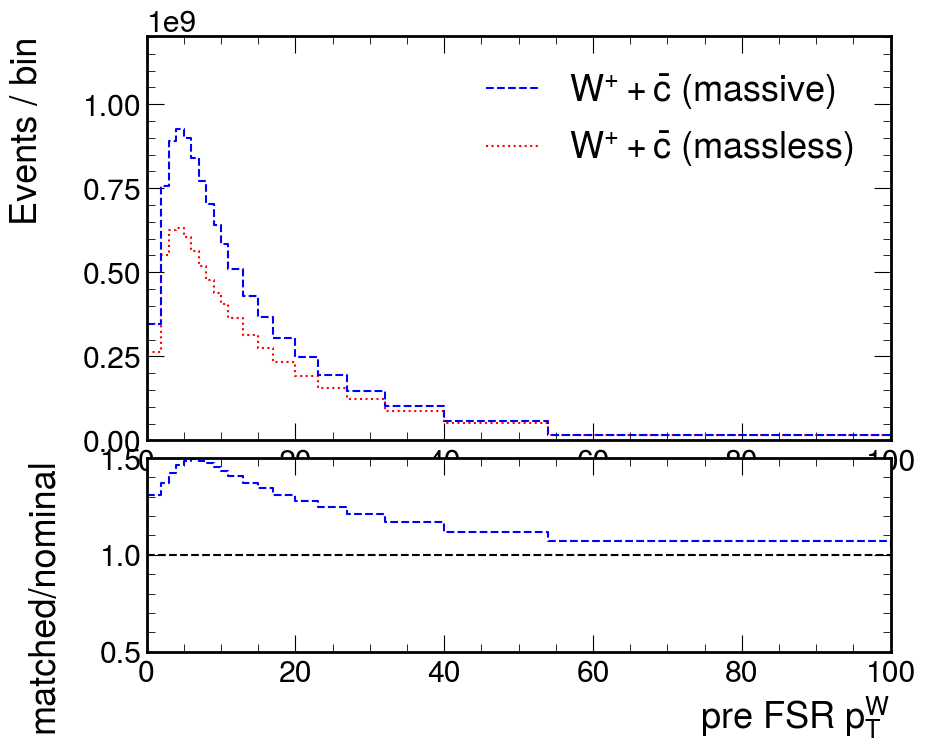

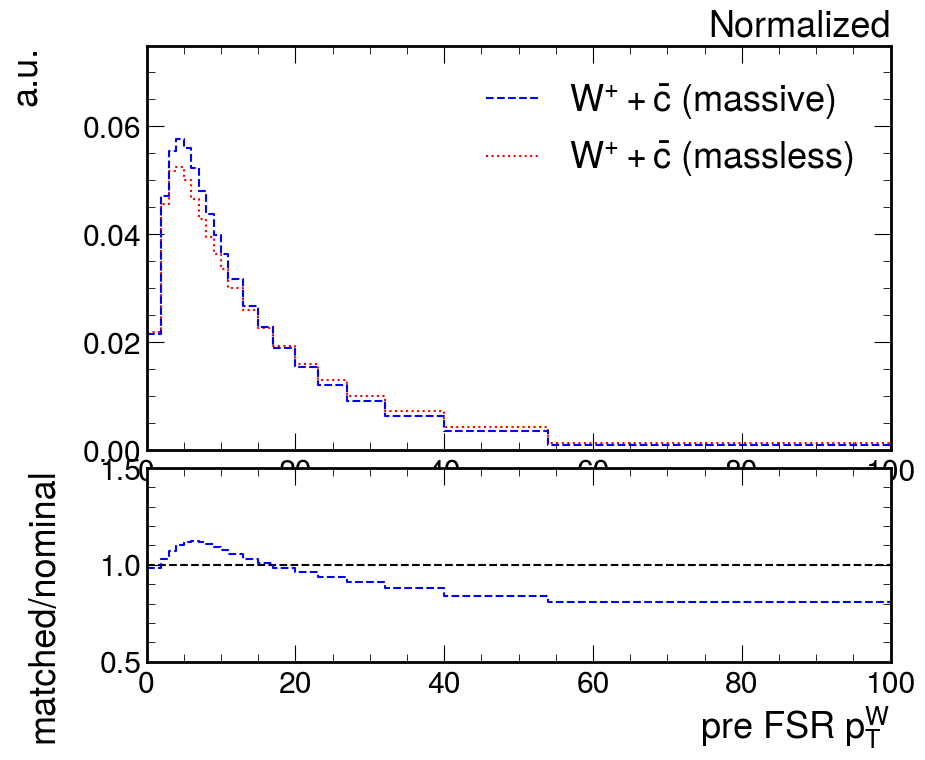

In [28]:
for i, (hCharm, hNominal) in enumerate(zip(WCharmToMuNu, WmunuPostVFP)):
    for var in ["massVgen","absYVgen", "ptVgen"]:
        hN = hNominal.project(var)
        hC = hCharm.project(var)
        hNC = hNominal[{"charm":1}].project(var)
        hNNC = hNominal[{"charm":0}].project(var)
        hM = hh.addHists(hNNC, hC)
        if i==0:
            labels = [r"$W^{-}+{c}$ (massive)", r"$W^{-}+{c}$ (massless)"]
            # labels = [r"$W^{-}$ nominal", r"$W^{-}$ matched", ]
        else:
            labels = [r"$W^{+}+\bar{c}$ (massive)", r"$W^{+}+\bar{c}$ (massless)"]
            # labels = [r"$W^{+}$ nominal", r"$W^{+}$ matched", ]

        # plot([hN, hM][::-1], labels[::-1], var, plotname="Wminus" if i==0 else "Wplus", ratio=True)
        # plot([hN, hM][::-1], labels[::-1], var, plotname="Wminus" if i==0 else "Wplus", ratio=True, normalize=True)
        
        plot([hNC, hC], labels[::-1], var, plotname="Wminus" if i==0 else "Wplus", ratio=True)
        plot([hNC, hC], labels[::-1], var, plotname="Wminus" if i==0 else "Wplus", ratio=True, normalize=True)
        # plot([hC, hNC], ["W+c (massive)", "W+c (massless)"], var)

In [29]:
outdir = "/eos/home-d/dwalter/www/WMassAnalysis/2025/"
outfile = "250305_WCharm"
output_tools.write_index_and_log(
    "./",
    outfile,
)
output_tools.copy_to_eos(f"./{outfile}", f"{outdir}/{outfile}")

PermissionError: [Errno 13] Permission denied: '/eos/home-d/dwalter/www/WMassAnalysis/2025//index.php'